# Energy prediction of 1D Ising model using neural networks

This notebook shows our implementation of a neural network in action on predicting the energy of the 1D Ising model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
import project2_tools as proj2_tools

## Load and split data
Generate random spins and calculate their energies using nearest neighbor interactions.

In [98]:
L = 40
N = 1000

from sklearn.model_selection import train_test_split
data_input, data_targets = proj2_tools.gen_1Ddata(n_spins = L, n_sets = N) 
data_targets = np.atleast_2d(data_targets).T

temp = train_test_split(data_input, data_targets, test_size = 0.33)
input_train, input_test, target_train, target_test = temp
data_input.shape, data_targets.shape

((1000, 1600), (1000, 1))

# This function runs and trains several networks

In [100]:

from result_functions import run_minibatch_sgd as sgd

params = { 'n_batches':200, 'min_epochs':10, 'max_epochs':50,
        'tol':1e-10, 'hidden_act_func':'sigmoid',
        'output_act_func':'identity', 'net_type':'regression',
        'earlystopping':True}

df = sgd(input_train,target_train, input_test, target_test, eta_values = [10**(-1)],  
         n_hidden_values = [8, 16, 32, 64, 128],
   file_name_append = 'regr_sig', save_df = True, **params)
df

n hidden nodes:  128
eta:  0.1
batch size:  3
batch, epoch, accuracy
    0/200     14/50  0.56
Time estimate: 37 seconds left
earlystop at epoch number 15, cond 1
saving file output/mb_sgdregr_sig_38.pickle


,accuracy,epochs,eta,n_batches,nhidden,final_accuracy,max_accuracy
0,"[0.00011947904486753202, 0.1716893568114931, 0...",16,0.1,200,8,0.421449,0.482833
1,"[-0.007316721121811254, 0.33560575405432247, 0...",11,0.1,200,16,0.518947,0.537755
2,"[-0.0019340073610178976, 0.362787959856984, 0....",14,0.1,200,32,0.546729,0.560281
3,"[-0.007592328915099644, 0.32569588389458537, 0...",13,0.1,200,64,0.547469,0.561515
4,"[-0.01709696229216462, 0.4217702695612644, 0.4...",15,0.1,200,128,0.564324,0.571248


# Load premade data

See `Neural Net Classification.ipynb` for disclaimer

In [103]:
files = glob.glob('output/mb_sgdregr_sig_*.pickle')
files_sigmoid = [f for f in files if ('0' in f) or ('1' in f)]
files_relu = [f for f in files if ('2' in f) or ('3' in f)]

In [104]:
df_sig = pd.concat([pd.read_pickle(f) for f in files_sigmoid], ignore_index = True)
df_sig.loc[df_sig.nhidden.apply(type) == list, 'nhidden'] = 0

df_relu = pd.concat([pd.read_pickle(f) for f in files_relu], ignore_index = True)
df_relu.loc[df_relu.nhidden.apply(type) == list, 'nhidden'] = 0

for df, name in zip([df_relu, df_sig], ['relu','sigmoid']):
    df['hidden_act'] = name
    df['eta_val'] = np.log10(df['eta'])
    df['optimal_epoch'] = df['accuracy'].apply(np.argmax)+1

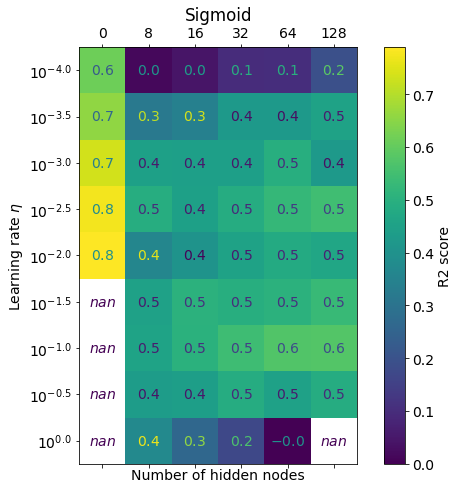

In [69]:
from plotting import PlotWrap
from project2_tools import eta_nhidden_df

plotter = PlotWrap(savefigs = True)

data = eta_nhidden_df(df_sig)
x = data.index
y = data.columns

plotter.plot_score(data.values.T, x, y, value = 'r2', lognorm = False, cmap = plt.cm.viridis,
                  filename = 'r2_sigmoid', title= 'Sigmoid')

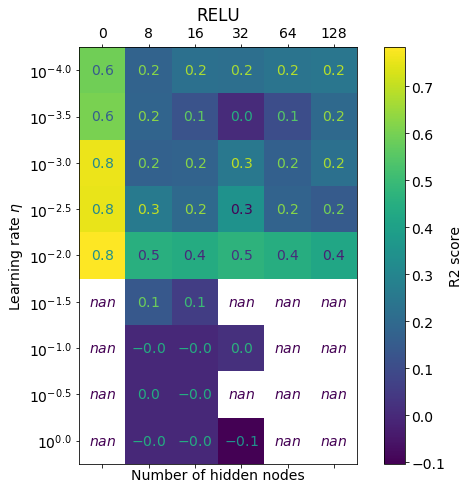

In [70]:
data = eta_nhidden_df(df_relu)
x = data.index
y = data.columns

plotter.plot_score(data.values.T, x, y, value = 'r2', lognorm = False, cmap = plt.cm.viridis,
                  filename = 'r2_relu', title= 'RELU')

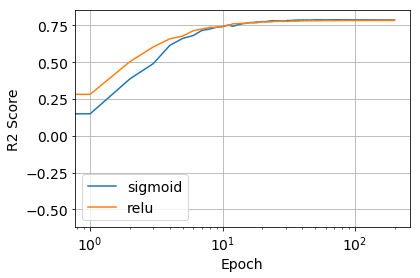

In [106]:
super_df = pd.concat([df_sig, df_relu], ignore_index= True)
plotter.plot_best([df_sig,df_relu], r2 = True)

In [107]:
from plotting import gen_best_table
print(gen_best_table([df_sig, df_relu], max_acc_name = 'R2 Score'))

\begin{tabular}{llrrlrr}
\toprule
{} & \multicolumn{3}{l}{relu} & \multicolumn{3}{l}{sig} \\
{} &     $\eta$ & R2 Score & Epoch &     $\eta$ & R2 Score & Epoch \\
$N_h$ &            &          &       &            &          &       \\
\midrule
0     &  10^{-2.0} &    0.784 & 199.0 &  10^{-2.0} &    0.789 &  66.0 \\
8     &  10^{-1.0} &    0.483 &   5.0 &  10^{-2.5} &    0.490 &  79.0 \\
16    &  10^{-1.0} &    0.577 &  10.0 &  10^{-1.5} &    0.506 &  13.0 \\
32    &  10^{-1.0} &    0.560 &   9.0 &  10^{-1.0} &    0.545 &   5.0 \\
64    &  10^{-1.0} &    0.582 &   8.0 &  10^{-1.0} &    0.575 &   5.0 \\
128   &  10^{-1.0} &    0.610 &   7.0 &  10^{-1.0} &    0.578 &   7.0 \\
256   &  10^{-1.0} &    0.614 &   8.0 &   10^{nan} &      NaN &   NaN \\
512   &  10^{-1.0} &    0.388 &   5.0 &   10^{nan} &      NaN &   NaN \\
1024  &  10^{-1.0} &   -0.050 &   1.0 &   10^{nan} &      NaN &   NaN \\
2048  &  10^{-1.0} &   -0.113 &   1.0 &   10^{nan} &      NaN &   NaN \\
\bottomrule
\end{tabular}